# <center>Autoencoder variacional condicional</center>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}.')

### Datos de entrenamiento

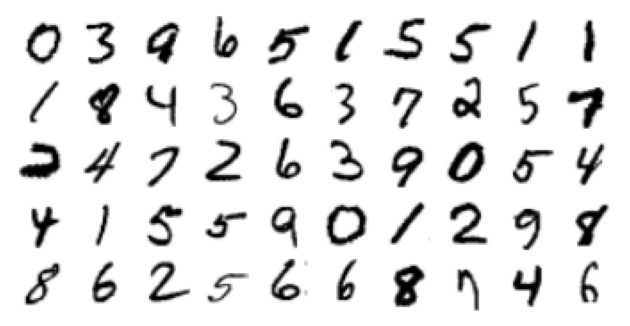

In [23]:
transf = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
dataset = datasets.MNIST('data', train=True, transform=transf, download=True)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)

def show_batch(images):
    grid_tensor = utils.make_grid(images, nrow=10)
    plt.axis('off')
    plt.imshow(1-grid_tensor.permute(1, 2, 0))
    plt.tight_layout()
    plt.show()

# Ejemplo:
batch_x, batch_y = next(iter(dataloader))
show_batch(batch_x[:50])

### Redes neuronales

In [3]:
class Encoder(nn.Module):

    def __init__(self, image_size, latent_dim, n_classes=10):
        super().__init__()

        self.n_classes = n_classes

        conv = lambda in_ch, out_ch: nn.Conv2d(in_ch, out_ch, 3, 2, 1)
        c, h, w = image_size
        flatten_dim = 64 * (h // 8) * (w // 8)
        
        self.encoder = nn.Sequential(
            conv(c + n_classes, 16), nn.ReLU(),
            conv(16, 32), nn.ReLU(),
            conv(32, 64), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(flatten_dim, 2 * latent_dim)
        )

    def forward(self, x, y):
        # x.shape = [batch_size, c, h, w].
        # y.shape = [batch_size].

        batch_size, c, h, w = x.shape
        y_emb = F.one_hot(y, self.n_classes)  # [batch_size, n_classes].
        y_emb = y_emb[:, :, None, None].expand(batch_size, self.n_classes, h, w)   # [batch_size, n_classes, h, w].
        
        x_cond = torch.cat([x, y_emb], dim=1)  # [batch_size, c + n_classes, h, w]

        mean, logstd = self.encoder(x_cond).chunk(2, dim=-1)
        std = logstd.exp()
        return mean, std

In [ ]:
class Decoder(nn.Module):

    def __init__(self, image_size, latent_dim, n_classes):
        super().__init__()

        c, h, w = image_size
        flatten_dim = 64 * (h // 8) * (w // 8)
        self.n_classes = n_classes

        deconv = lambda in_ch, out_ch: nn.ConvTranspose2d(in_ch, out_ch, 3, 2, 1, 1)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + n_classes, flatten_dim),
            nn.ReLU(),
            nn.Unflatten(1, (64, h // 8, w // 8)),
            deconv(64, 32), nn.ReLU(),
            deconv(32, 16), nn.ReLU(),
            deconv(16, c), nn.Sigmoid()
        )

    def forward(self, z, y):
        # z.shape = [batch_size, latent_dim].
        # y.shape = [batch_size].

        y_onehot = F.one_hot(y, self.n_classes)  # [batch_size, n_classes].
        z_cond = torch.cat([z, y_onehot], dim=-1)  # [batch_size, latent_dim + n_classes].
        x_hat = self.decoder(z_cond)
        return x_hat

### Clase VAE

In [5]:
class VAE:

    def __init__(self, image_size=(1, 32, 32), latent_dim=128, n_classes=10, device=device):
        
        self.image_size = image_size
        self.latent_dim = latent_dim
        self.device = device

        self.encoder = Encoder(image_size, latent_dim, n_classes)
        self.decoder = Decoder(image_size, latent_dim, n_classes)
        self.encoder_optimizer = optim.AdamW(self.encoder.parameters())
        self.decoder_optimizer = optim.AdamW(self.decoder.parameters())

        self.encoder.to(device)
        self.decoder.to(device)    
    
    
    def train(self, dataloader, epochs):

        self.encoder.train()
        self.decoder.train()

        for _ in range(epochs):
            for x, y in dataloader:
                x, y = x.to(self.device), y.to(self.device)
                loss = self.calc_loss(x, y)

                # Optimización:
                self.encoder_optimizer.zero_grad()
                self.decoder_optimizer.zero_grad()
                loss.backward()
                self.encoder_optimizer.step()
                self.decoder_optimizer.step()


    def calc_loss(self, x, y):
        # x.shape = [batch_size, c, h, w].
        # y.shape = [batch_size].

        # Prior matching:
        encoder_mean, encoder_std = self.encoder(x, y)
        prior_matching = 1/2 * (encoder_mean.norm(dim=-1) ** 2 + encoder_std.norm(dim=-1) ** 2) - encoder_std.log().sum(dim=-1)

        # Término de reconstrucción:

        z = encoder_mean + encoder_std * torch.randn_like(encoder_mean)  # muestra desde q(z|x) para aproximar E_{q(z|x)}[...].
        x_hat = self.decoder(z, y)

        x = x.flatten(start_dim=1)  # tamaño [batch_size, c * h * w].
        x_hat = x_hat.flatten(start_dim=1).clamp(1e-7, 1-1e-7)
        reconstruction_term = (x * x_hat.log() + (1 - x) * (1 - x_hat).log()).sum(dim=-1)

        elbo = reconstruction_term - prior_matching
        return - elbo.mean()


    def generate_samples(self, y, n_samples):

        self.decoder.eval()

        with torch.no_grad():
            y = torch.tensor(y, device=self.device).expand(n_samples)
            z = torch.randn(n_samples, self.latent_dim, device=self.device)
            x_hat = self.decoder(z, y)
            
        return x_hat

In [6]:
vae = VAE()
vae.train(dataloader, epochs=50)

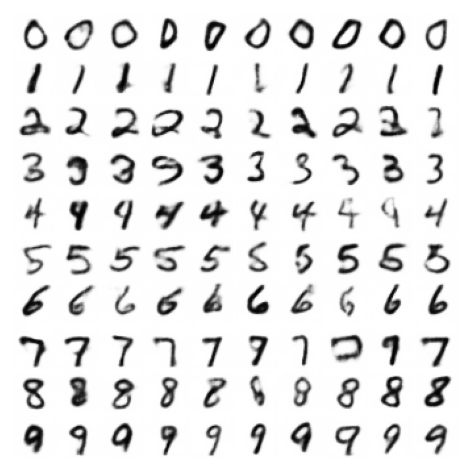

In [27]:
# Generación.

samples = [vae.generate_samples(y, n_samples=10) for y in range(10)]
samples = torch.cat(samples, dim=0)
show_batch(samples.cpu())